##### Copyright 2025 Google LLC.

# Google intensive agent course submission

**Track: Concierge Agents: ShopAIholic**


Category 1: The Pitch (Problem, Solution, Value)

### Problem:

The need to buy, cook and eat food is one of the few things that connects all 8.2 billion people living on Earth. Many of these people - especially in EU and NA increasingly want to not only eat something but rather eat high quality, nutritious and balanced diet, while also navigating numerous supermarket offers, time-limited discounts and, ultimately, saving money.

That requires careful planning, which takes a lot of time many people do not have. This makes it a perfect use-case for an agentic system.



### Solution:

ShopAIholic is a multi-agent system that helps users create their shopping lists and finds the cheapest nearby supermarket to buy everything they need.

It does so by engaging directly with the user to discover - and remember - their dietary goals, such as saving as much money as possible, gaining lean muscle, increasing their longevity or simply eating tasty food. Furthermore, it keeps track of user's food storage and verifies with the user by providing them with a list of foods and quantities they're supposed to have at home and updating its persistent memory based on new information. This behaviour is fully optional and the user is asked if they'd like to engage with the food storage memory feature.

Once user's dietary goals are established, it uses its Meal Planner sub-agent to derive a meal plan that matches users' goals. An overview of this plan is first presented to the user and changes are made based on feedback (e.g. "I don't like broccoli", which results in removal of broccoli meals as well as addition of this preference into persistent memory). This sub-agent is equipped with a recipe book API tool and Google search, which allows it to select tasty meals, which also follow dietary trends (since Google search is included).

When the meal plan is accepted by the user, next sub-agent, the Ingredient Aggregator, is used. The purpose of this sub-agent is to evaluate the amounts of individual ingredients that the user needs to buy. It dos so by iterating through the meal plan, summing up ingredients needed and using the persistent memory to access user's storage information. This reduces waste and saves the user money. To precisely evaluate the amount of ingredients needed, this sub-agent has access to a recipe book API tool, Google search as well as food storage memory knowledge within this system. 

The last piece of the puzzle that remains is to take the generated list of ingredients and find the cheapest place to do the shopping. This is the purpose of our last sub-agent, the Store Finder. It uses a geolocation tool to find shops near user's place of stay (within user specified range threshold). For these shops, it attempts to look up the price lists using APIs and Google Search, in case the use of APIs fails. The prices for each shops are then aggregated and the lowest total is given to the user along with the shopping list in a format of (store name - store address - $total; (list) item name - item quantity - total item price). The user is asked whether they agree with this shop or they'd like to reiterate some steps (e.g. choose another shop).



### Value:

For every user at least one of (3) options or their combination:

A) Average of ±60 minutes weekly saved on meal planning. `
[this is in the case the user is already actively planning their meals]
B) Significantly improved diet due to reasoning-driven planning based on user's goals. Up to 8-10 years of health span added (estimation based on longevity studies)
[this is in the case the user had poorly organised and/or unbalanced diet, which this agentic solution improves]
C) Around 10-20% groceries cost reduction.
[not guaranteed as vegetables cost more than instant noodle diet but overall value is still improved, savings can be specified via user interaction]


# The architecture: a brief overview 
More detailed description can be found in README.md

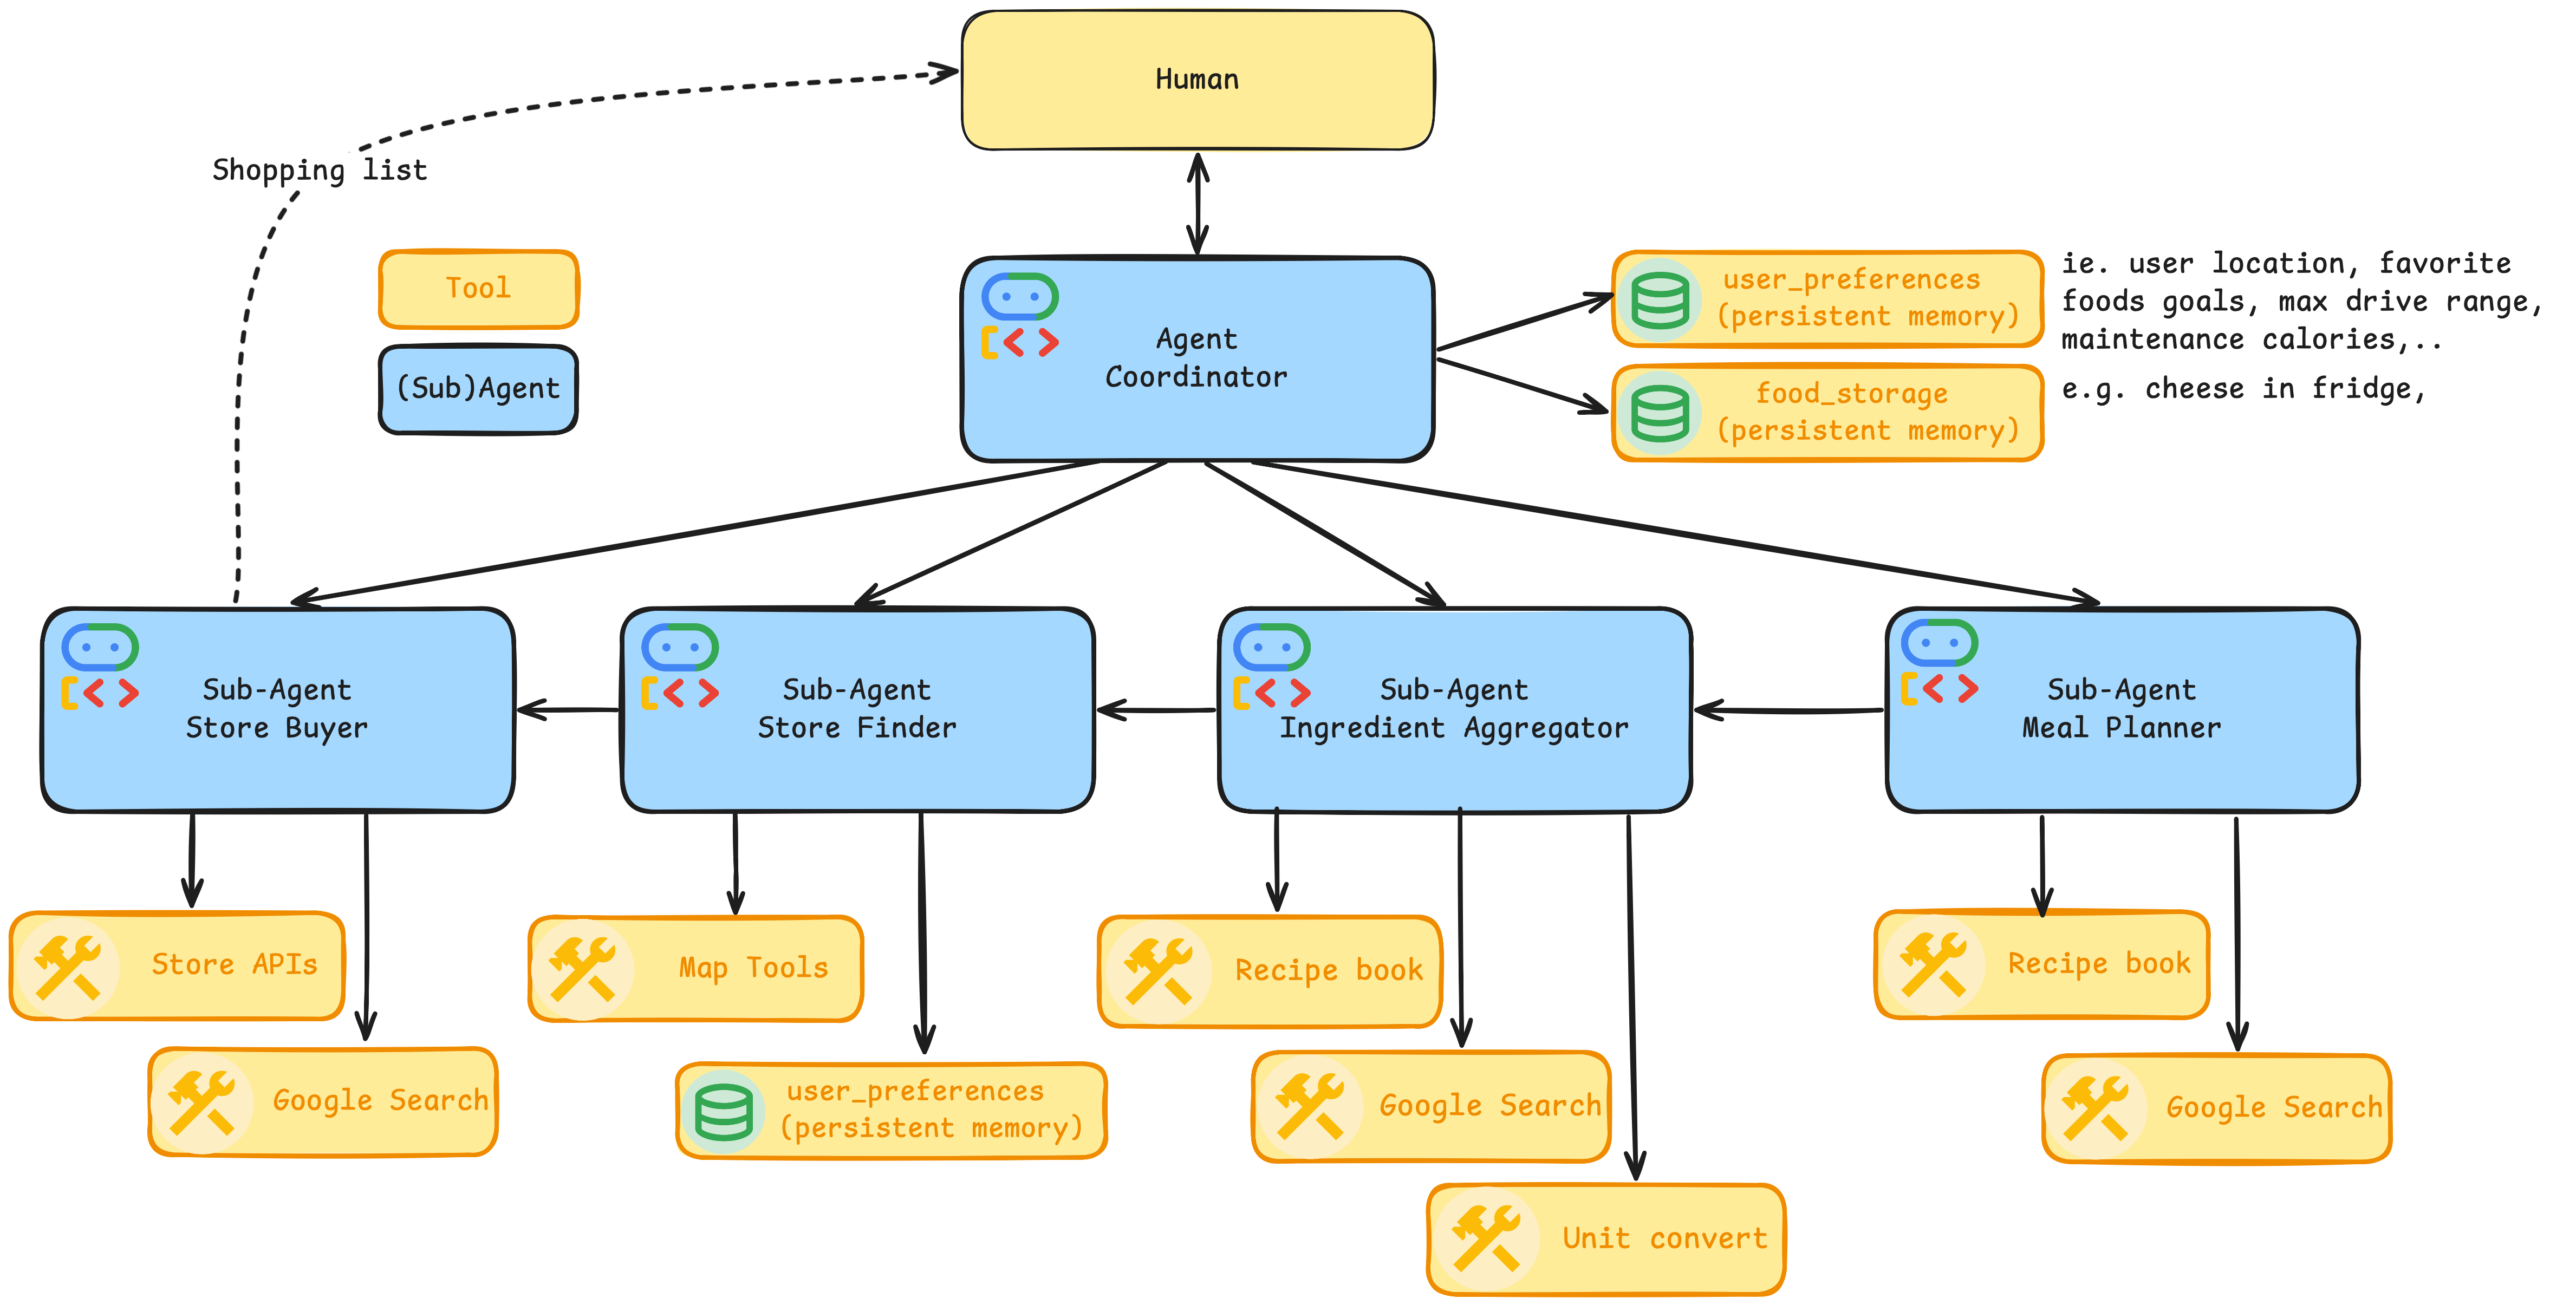

## Root agent
The root agent is responsible for communication with the user as well as direct the general workflow. While it's role is absolutely vital to the success of the system, 
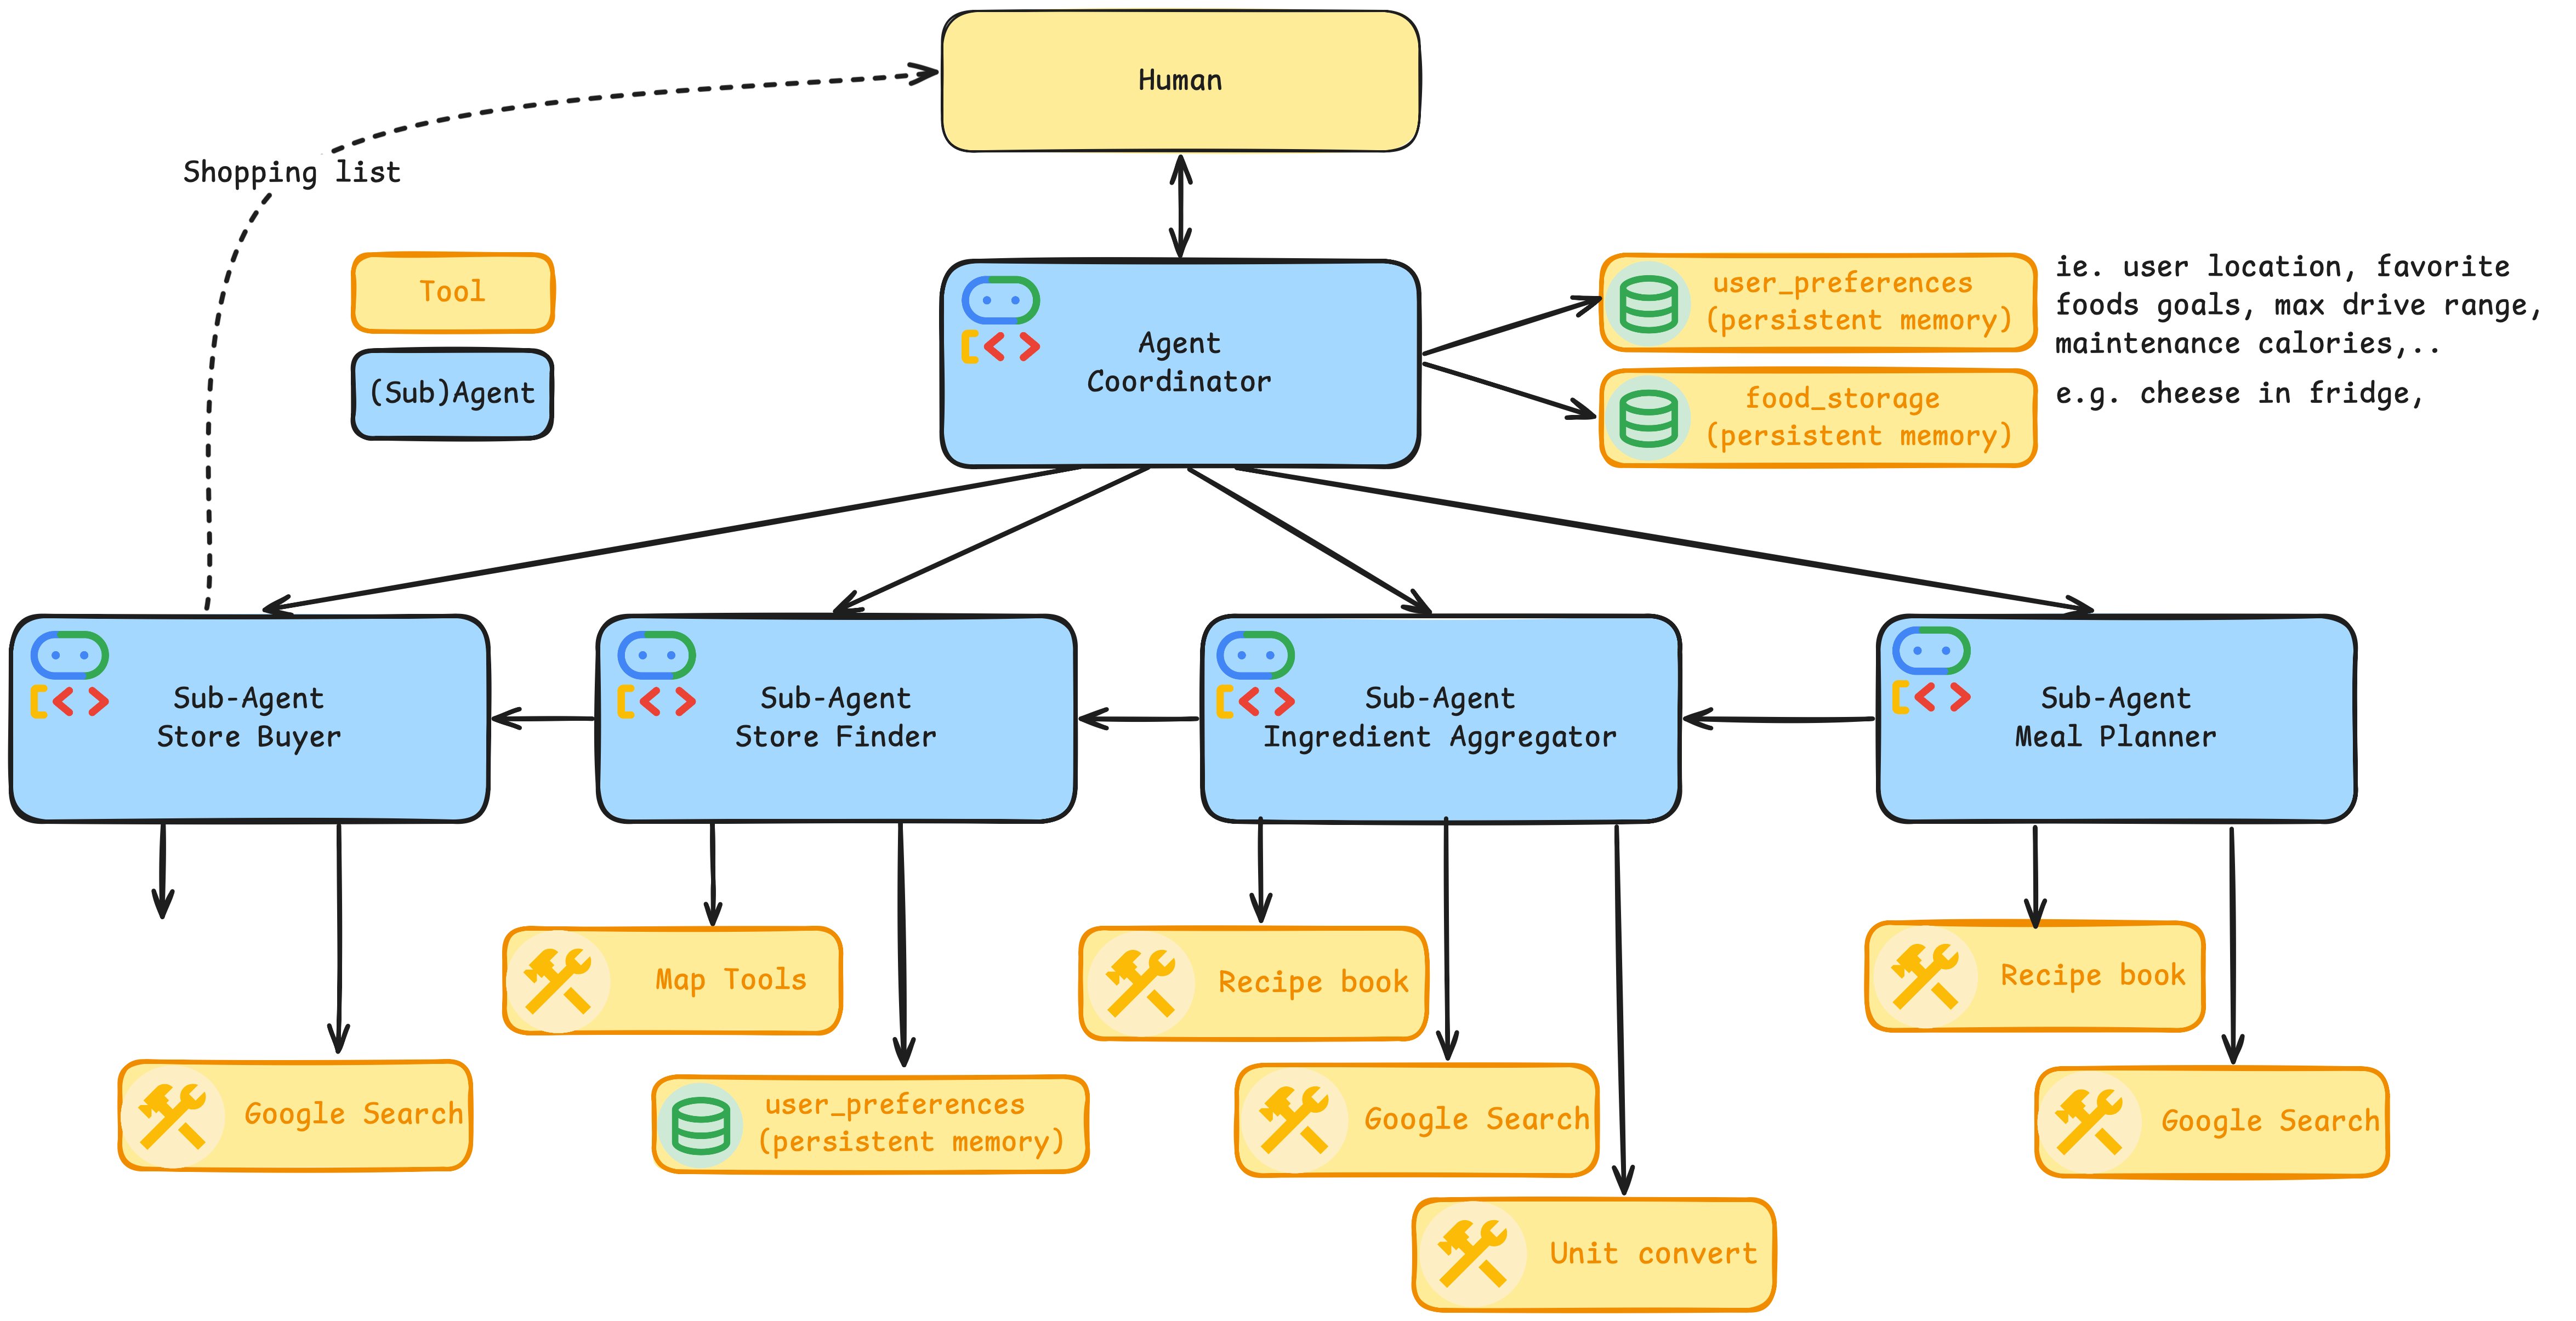

In [ ]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Setup and authentication complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

In [ ]:
import uuid
from google.genai import types

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService

from google.adk.tools.mcp_tool.mcp_toolset import McpToolset
from google.adk.tools.tool_context import ToolContext
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters

from google.adk.apps.app import App, ResumabilityConfig
from google.adk.tools.function_tool import FunctionTool

print("✅ ADK components imported successfully.")

In [ ]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

# Tool definitions

Bellow, we define tools needed for our project. 

In [ ]:

memory_service = VertexAiMemoryBankService(
    project_id="shopAIholic",
    location="europe-west4"
)


In [ ]:
from google.adk.tools import tool
from google.adk.context import context
from google.adk.memory import VertexAiMemoryBankService
from typing import Dict, Any
import math

"""
This function serves to estimate maintenance calories based on parameters:

Calculations based on:
For women, it's: BMR = 655.1 + (9.563 × weight in kg) + (1.850 × height in cm) - (4.676 × age).
For men, the formula is: BMR = 66.5 + (13.75 × weight in kg) + (5.003 × height in cm) - (6.75 × age).
"""
def calculate_maintenance_calories(age: int, weight_kg: float, height_cm: float, gender: str) -> int:
    """Harris-Benedict formula for maintenance calories (sedentary)."""
    if gender.lower() == "male":
        bmr = 66.5 + (13.75 * weight_kg) + (5.003 * height_cm) - (6.75 * age)
    else:
        bmr = 655.1 + (9.563 * weight_kg) + (1.850 * height_cm) - (4.676 * age)
    return int(bmr * 1.25) # light activity level as default 

@tool
def user_preferences(action: str = "retrieve", **kwargs) -> Dict[str, Any]:
    """
    Retrieve/save permanent user shopping/diet preferences + address from persistent memory.
    The purpose of this tool is to allow build up information about user's preferences and medical
    limitations, which helps the agents provide better service.
    Args:
        action: "retrieve" or "save".
        days: int (shopping days ahead).
        meals: list[str] (["breakfast", "dinner"]).
        goal: str ["bulking", "diet", "healthy", "saving_money"].
        maintenance_calories: int (or age/weight_kg/height_cm/gender).
        allergies: list[str] (["peanuts", "lactose"]).
        likes: list[str] (["steak", "avocado"]).
        address: dict ({"street": "Main St 123", "city": "Prague", "zip": "11000", "country": "Czechia"}).
        max_distance: float (max range to look for shops)
    
    Returns: Full preferences dict.

    example save call:
    user_preferences("save",
        days=7,
        meals=["breakfast", "dinner"],
        goal="bulking",
        allergies=["peanuts"],
        address={
            "street": "Long Street 321",
            "city": "Prague",
            "zip": "190 00",
            "country": "Czechia"
        }
    )
    example retrieve call:
    result = user_preferences(action="retrieve")
    result is {
      "days": 14,
      "meals": ["breakfast", "dinner"],
      "goal": "bulking",
      "maintenance_calories": 2800,
      "allergies": ["peanuts"],
      "likes": ["steak", "avocado"],
      "address": {
        "street": "Street 123",
        "city": "MyCity",
        "zip": "12355", 
        "country": "Estonia"
      },
      "max_distance": 10
    }
    """
    user_id = context.user_id
    # tool-specific key
    key = f"user:{user_id}:shopping_prefs"
    # default values
    default_prefs = {
        "days": 7,
        "meals": ["breakfast", "lunch", "dinner"],
        "goal": "healthy",
        "maintenance_calories": 2500,
        "allergies": [],
        "likes": [],
        "address": {}
    }
    # get user preferences from the memory - defaults to start from something
    prefs = memory_service.get(key, default_prefs)
    
    if action == "save":
        # Calorie calculation if knowledge available
        if all(k in kwargs for k in ["age", "weight_kg", "height_cm", "gender"]):
            prefs["maintenance_calories"] = calculate_maintenance_calories(
                kwargs["age"], kwargs["weight_kg"], kwargs["height_cm"], kwargs["gender"]
            )
        
        # Update all fields - all shouldn't be mandatory 
        fields = ["days", "meals", "goal", "maintenance_calories", "allergies", "likes", "address"]
        for field in fields:
            if field in kwargs:
                prefs[field] = kwargs[field]
        # save
        memory_service.set(key, prefs)
        return {"status": "saved", "preferences": prefs}
    
    return prefs


In [ ]:
from google.adk.context import context
from google.adk.memory import VertexAiMemoryBankService
from google.adk.tools import tool
from typing import Dict, Any


@tool
def food_storage(action: str = "retrieve", **kwargs) -> Dict[str, Any]:
    """
    Retrieve or update user's food storage.
    
    Args:
        action: "retrieve" (list all), "add" (item: str), "remove" (item: str).
        item: str (e.g. "500g chicken breast").
    
    Returns: 
        retrieve: {"pantry": ["500g chicken", "2l milk"]}
        add/remove: {"status": "added/removed", "pantry": [...]}

    Example calls:
    food_storage("add", item="2l whole milk")
    food_storage("retrieve")
    food_storage("remove", item="500g chicken breast")
    """
    user_id = context.user_id or "default_user
    # unique key
    key = f"user:{user_id}:pantry"
    
    # Load pantry from Vertex AI Memory Bank (default empty)
    pantry = memory_service.get(key) 
    if pantry is None:
        pantry = []

    # if user wants to retrieve, return contents of pantry
    if action == "retrieve":
        return {"pantry": pantry}

    # if user wants to add, add items 
    # TODO: instead of setting everything, we should add existing resources (e.g. have 2 eggs, buys 6 = 8 eggs)
    elif action == "add" and "item" in kwargs:
        item = kwargs["item"]
        if item not in pantry:
            pantry.append(item)
            memory_service.set(key, pantry)
        return {"status": "added", "pantry": pantry}

    # if user wants to remove, remove items
    # TODO: as above - subtract functionality needs to be added
    elif action == "remove" and "item" in kwargs:
        item = kwargs["item"]
        if item in pantry:
            pantry.remove(item)
            memory_service.set(key, pantry)
        return {"status": "removed", "pantry": pantry}
    
    return {"error": "Invalid action or missing item"}


In [ ]:
# TODO: This tool is only a simple moc. Due to time constraints, I haven`t had the time to fully implement these.

@tool  
def recipe_book(keywords: list) -> list:
    """Get recipes by keywords
    example call: recipe_book(['protein', 'bulking', broccoli']) 
    returns list[json]: ["{'name': ''Spicy chicken breasts with rice and broccoli' 
                   'recipe': Roast chicken with spice mix, steam 250g of brocoli,..'
                   'ingredients': '150g chicken breasts, 80g rice, 250g brocoli'}",
                   "...",...]
    """
    # Return mock recipes
    recipes = [
        """{
            "name": "Spicy Chicken Breasts with Rice and Broccoli",
            "recipe": "Season 150g chicken breasts with paprika, garlic, cayenne. Grill 6-8 min per side. Cook 80g rice. Steam 250g broccoli 5 min. Serve with hot sauce.",
            "ingredients": "150g chicken breasts, 80g rice, 250g broccoli, spices"
        }""",
        """{
            "name": "Bulking Broccoli Beef Stir Fry",
            "recipe": "Slice 200g beef sirloin thin. Stir fry with 300g broccoli, garlic, soy sauce 5 min. Serve over 100g cooked white rice for extra calories.",
            "ingredients": "200g beef sirloin, 300g broccoli, 100g rice, soy sauce, garlic"
        }""",
        """{
            "name": "High Protein Broccoli Chicken Casserole",
            "recipe": "Mix 200g cooked chicken, 400g steamed broccoli, 100g Greek yogurt, 50g cheddar. Bake 20 min at 180C.",
            "ingredients": "200g chicken, 400g broccoli, 100g Greek yogurt, 50g cheddar, breadcrumbs"
        }"""
    ]
    return recipes

@tool  
def recipe_book(keywords: list) -> list:
    """Get recipes by keywords
    example call: recipe_book(['protein', 'bulking', broccoli']) 
    returns list[json]: ["{'name': ''Spicy chicken breasts with rice and broccoli' 
                   'recipe': Roast chicken with spice mix, steam 250g of brocoli,..'
                   'ingredients': '150g chicken breasts, 80g rice, 250g brocoli'}",
                   "...",...]
    """
    # Return mock recipes
    recipes = [
        """{
            "name": "Spicy Chicken Breasts with Rice and Broccoli",
            "recipe": "Season 150g chicken breasts with paprika, garlic, cayenne. Grill 6-8 min per side. Cook 80g rice. Steam 250g broccoli 5 min. Serve with hot sauce.",
            "ingredients": "150g chicken breasts, 80g rice, 250g broccoli, spices"
        }""",
        """{
            "name": "Bulking Broccoli Beef Stir Fry",
            "recipe": "Slice 200g beef sirloin thin. Stir fry with 300g broccoli, garlic, soy sauce 5 min. Serve over 100g cooked white rice for extra calories.",
            "ingredients": "200g beef sirloin, 300g broccoli, 100g rice, soy sauce, garlic"
        }""",
        """{
            "name": "High Protein Broccoli Chicken Casserole",
            "recipe": "Mix 200g cooked chicken, 400g steamed broccoli, 100g Greek yogurt, 50g cheddar. Bake 20 min at 180C.",
            "ingredients": "200g chicken, 400g broccoli, 100g Greek yogurt, 50g cheddar, breadcrumbs"
        }"""
    ]
    return recipes

# maps tools available in MPCToolset
maps_toolset = MCPToolset(
    connection_params=StdioServerParameters(
        command="npx",
        args=["-y", "@modelcontextprotocol/server-google-maps"],
        env={"GOOGLE_MAPS_API_KEY": "<YOUR_API_KEY>"},
    )
)


In [2]:
# Agent-model_size dictionary

# Developer note: due to time constraints, I haven't had the time to properly tweak these, hence these values are my expectations
# rather than fine-tuned values with optimal cost-speed-quality trade-off.
MODEL_MAP = {
    "meal_orchestrator": "gemini-2.5-flash",        # user interaction - speed needed. Selected flash over flash-lite due to lengthy instructions (worried it might fail get distracted otherwise)
    "meal_planner": "gemini-2.5-pro",               # planning meals based on the requirements, req. stronger reasoning capacity 
    "ingredient_aggregator": "gemini-2.5-flash",    # lookup + basic math capabilities
    "store_finder": "gemini-2.5-flash-lite",        # API / Google search usage
    "store_buyer": "gemini-2.5-flash"               # basic math + lookup / API usage
}


In [ ]:
# 1. CREATE SUB-AGENTS FIRST
meal_planner = LlmAgent(
    name="meal_planner",
    model=Gemini(model=MODEL_MAP["meal_planner"]),
    instruction="""You are a nutritionist model and your task is to generate a meal plan from user preferences. 
    Keep in mind user preferences such as:
       - how many days are we shopping for
       - which meals are they going to eat (e.g. no lunch as they eat at home)
       - [bulking/diet/healthy/saving money]
       - maintenance calories (if user doesnt know approximate for their age, weight and gender)
       - any food allergies and intolerances
       - food user likes
    Provide a nutritious, diverse meal plan. Use mainly less difficult recipes without excessive cooking time.
    Ensure the plan contains a balanced combination of protein, fat and carbs. Include a good balance of vegetables
    fruits and grains. When possible, include mainly generally affordable foods (such as mozarella, carrots, beans, 
    banana, apples,.).
    Where possible, plan meals which include ingredients already available in user's pantry.
    
    Output: meal plan JSON: {day: {breakfast: '...', lunch: '...', snacks: '...'}}
    """,
    tools=[google_search, recipe_book]  
)

ingredient_aggregator = LlmAgent(
    name="ingredient_aggregator", 
    model=MODEL_MAP["ingredient_aggregator"],
    instruction="""
    Your task is to convert the meal plan JSON generated by the meal_planner sub-agent into an aggregated list of 
    individual ingredients needed to prepare all the meals. You can use the recipe_book tool to find ingredients for 
    particular recipes and google_search to find recipe ingredients when needed. 
    Use ingredients commonly available in supermarkets.
    Output: (list) {ingredient: quantity}""",
    tools=[unit_converter, google_search, recipe_book]
)

store_finder = LlmAgent(
    name="store_finder",
    model=MODEL_MAP["store_finder"],
    instruction="""
    Your task is to find stores near user's address. Utilize the user_preferences tool to find user's address and desired
    shopping range. Utilize maps_toolset tools to achieve following:
    1. Geocode user address (User's address into lat/lng coordinates)
    2. Find nearby supermarkets (e.g. Albert, Lidl, Kaufland,..) within max_distance parameter provided by user_preferences tool
    3. Place details - addresses and names for price lookup
    4. Return nearby stores sorted by distance .

    Suggested tool usage:
    Geocode user's address
    maps_geocode(address="Small square 42") 
    → Returns: {"lat": 59.266, "lng": 23.900}
    
    Find supermerkts nearby (km radius)
    maps_nearby_search(
        location={"lat": 59.266, "lng": 23.900}, 
        radius=10000, 
        type="supermarket"
    )
    → Returns: [{"name": "Albert", "place_id": "ChIJ...", "vicinity": "Big square 123"}]
    
    Get store detals  
    maps_place_details(place_id="ChIJ...")
    → Returns: {"name": "Awesome shop", "formatted_address": "Big square 123, NewTown 190 00"}

    Expected output - supermarket list:
    [
      {"name": "Albert", "address": "Big Square 123", "distance_km": 2.3, "place_id": "..."},
      {"name": "Lidl", "address": "E55 456", "distance_km": 8.1, "place_id": "..."}
    ]
    """,
    tools=[maps_toolset, user_preferences]  
)

store_finder = LlmAgent(
    name="store_buyer",
    model=MODEL_MAP["store_buyer"],
    instruction="""
    Iterate through each supermarket from the supermarket list. 
    .""",
    tools=[maps_toolset, supermarket_API_tools]  
)

In [ ]:
retry_plugin = ReflectAndRetryToolPlugin(max_retries=3)

root_agent = LlmAgent(
    name="meal_orchestrator",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""You are a nutrition and shopping list coordinator.
  
  Your goal is to give suggest user the cheapest supermarket to buy food at based on their preferences.
  You should follow this task list. 
   1. Engage in a conversation with the client. Figure out their dietary needs and preferences in order to understand what 
   they want to eat. 
   This includes: 
       - how many days are we shopping for
       - which meals are they making at home (e.g. are you eating lunch at home or at work)
       - [bulking/diet/healthy/saving money]
       - maintenance calories (if user doesnt know approximate for their age, weight and gender)
       - any food allergies and intolerances
       - food they enjoy
       - their address and shopping range
   Use tool user_preferences to retrieve relevant information and save this information if necessary.
   2. After you built user's preferences, sum this up in a clear overview and ask the user to confirm.
   3. Continue the conversation with the user. Use food_storage tool to retrieve information about user's food storage. 
   Then ask the user to confirm and add / remove any items they have at home. If the user wishes to skip this step, assume they
   dont have any ingredients at home. 
   4. Use the Meal Planner sub-agent to create a meal plan that satisfies these requirements. Once the Meal Planner sub-agent 
   creates the meal plan, communicate it to the user in a clear way and ask for confirmation or changes request. Use the
   Meal Planner sub-agent to make changes until user is satisfied.
   5. When the meal plan is finalized, use the Ingredient Aggregator sub-agent to generate a list of all ingredients needed. 
   Remember to subtract user's ingredients at home. 
   6. Once ingredients are aggregated, ensure the list does not contain anything the user is allergic to. If it does, go back 
   to step 4 with this new context.
   7. Use the Store Finder sub-agent to search for nearby shops and then use shop API tools where possible,
   otherwise use Google search tool to find out price list for the days. The Store Finder is prompted to process the ingredients 
   list into an ingredient-price list for each of nearby shops and select the shop where the total is the cheapest.
   8. Present the result to the user in a format using this example, make sure to respect local currency:
       Shop: Tesco, MyStreet 123, Prague
       Total: 13€
       List: Eggs 10-pack           - 2€,
             Milk 1l                - 1€,
             2x Chicken brests 500g - 10€
   9. If any sub-agent fails, use retry_plugin plugin to handle errors.
  """,
    tools=[user_preferences, food_storage],
    plugins=[retry_plugin],
    sub_agents=[meal_planner, ingredient_aggregator, store_finder, store_buyer],

)

print("✅ Shopping Agent created!")

In [ ]:
from google.adk.runners import InMemoryRunner
session_service = InMemorySessionService()
runner = InMemoryRunner(agent=image_agent)

async def run_agent():
    runner = Runner(
        agent=root_agent,
        app_name="meal_planner",
        session_service=session_service,
        memory_service=memory_service  
    )
    
    # Create session
    await runner.session_service.create_session(
        app_name="meal_planner", 
        user_id="user123", 
        session_id="session1"
    )
    
    # Run conversation
    async for event in runner.run_async(
        user_id="user123", 
        session_id="session1", 
        new_message="Initiate meal planning."
    ):
        print(event.content.parts[0].text)
